In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd 
import numpy as np
import math

In [3]:
train_df = pd.read_csv("/content/drive/Shareddrives/kdd dataset/binaryTraget_df.csv")
test_df=pd.read_csv("/content/drive/Shareddrives/kdd dataset/processed_test_df.csv")

In [4]:
df=train_df.loc[:,train_df.columns!='target']

In [5]:
df.head()

,su_attempted,dst_host_same_src_port_rate,count,logged_in,dst_host_srv_count,dst_host_same_srv_rate,srv_count,same_srv_rate,dst_host_rerror_rate,num_compromised,...,60,61,62,63,64,65,66,67,68,69
0,-0.024437,0.069972,-0.717045,-0.809262,-0.818890,-0.782367,-0.354343,0.771283,-0.224532,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.024437,2.367737,-0.620982,-0.809262,-1.035688,-1.161030,-0.368110,-1.321428,-0.387635,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.024437,-0.480197,0.339648,-0.809262,-0.809857,-0.938287,-0.299273,-1.389669,-0.387635,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.024437,-0.383108,-0.690846,1.235694,1.258754,1.066401,-0.313041,0.771283,-0.387635,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.024437,-0.480197,-0.472521,1.235694,1.258754,1.066401,0.058678,0.771283,-0.387635,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
clusters=[0]*df.shape[0]

In [7]:
#initial clusters
c1=df.iloc[0]
c2=df.iloc[1]

In [8]:
def euclideanDistance(point1,point2):
  s=0
  for i in range(len(point1)):
    s+=(point1[i]-point2[i])**2
  
  return math.sqrt(s)

In [9]:
num_iters=50

for i in range(num_iters):
  #print(i)
  count_c1=0
  count_c2=0
  for index, row in df.iterrows():
    #distance calculation from point to cluster
    d1=euclideanDistance(row,c1)
    d2=euclideanDistance(row,c2)
  
  
    #clustering based on distance
    if d1<=d2:
      clusters[index]=1
      count_c1+=1
    else:
      clusters[index]=2
      count_c2+=1
    
  #update cluster centers
  df['cluster']=pd.Series(clusters)

  #new clusters
  mean_c1=df[df['cluster']==1].mean(axis=0)
  mean_c1=mean_c1.drop(['cluster'])

  mean_c2=df[df['cluster']==2].mean(axis=0)
  mean_c2=mean_c2.drop(['cluster'])

  #update cluster centers
  c1=mean_c1
  c2=mean_c2
  
  #removing cluster column
  df.drop('cluster', inplace=True, axis=1)
    

Final clusters

In [10]:
print("Cluster_center1")
print(c1)
print("cluster_center_2")
print(c2)

Cluster_center1
su_attempted                  -0.019750
dst_host_same_src_port_rate   -0.311857
count                          0.741195
logged_in                     -0.803290
dst_host_srv_count            -0.929904
                                 ...   
65                             0.000000
66                             0.016465
67                             0.014560
68                             0.013057
69                             0.014666
Length: 104, dtype: float64
cluster_center_2
su_attempted                   0.011855
dst_host_same_src_port_rate    0.187197
count                         -0.444915
logged_in                      0.482188
dst_host_srv_count             0.558191
                                 ...   
65                             0.007647
66                             0.000025
67                             0.000013
68                             0.000000
69                             0.000000
Length: 104, dtype: float64


Saving cluster centers

In [11]:
c1_center=c1
c2_center=c2

In [12]:
c1_center.to_frame().T
c2_center.to_frame().T
cluster_centers=pd.concat([c1_center,c2_center],axis=0)
cluster_centers.head()
cluster_centers.to_csv("/content/drive/Shareddrives/kdd dataset/clustercenters.csv",index=False)

Label identification

In [13]:
train_df['target'].value_counts()

0    67343
1    58630
Name: target, dtype: int64

In [14]:
cluster1=pd.DataFrame(columns=df.columns)
cluster2=pd.DataFrame(columns=df.columns)

In [15]:
#cluster1 true positives
count_usual=0
count_unusual=0
for i in range(len(clusters)):
  if clusters[i]==1:
    if train_df['target'][i]==0:
      count_usual+=1
    else:
      count_unusual+=1


#cluster2 
count1_usual=0
count1_unusual=0
for i in range(len(clusters)):
  if clusters[i]==2:
    if train_df['target'][i]==0:
      count1_usual+=1
    else:
      count1_unusual+=1

In [16]:
print("normal")
print(count_usual)
print("attacks:")
print(count_unusual)

normal
318
attacks:
46935


In [17]:
print("normal")
print(count1_usual)
print("attacks:")
print(count1_unusual)

normal
67025
attacks:
11695


Evaluation

In [18]:
test_df['target'].value_counts()

1    12833
0     9711
Name: target, dtype: int64

In [19]:
test_points=test_df.loc[:,train_df.columns!='target']

In [20]:
clusters_test=[0]*test_points.shape[0]
count_attacks=0
count_normal=0

Cluster1: attacks
Cluster2: normal 

In [21]:
for i,r in test_points.iterrows():
   #distance calculation from point to cluster
    d1=euclideanDistance(r,c1)
    d2=euclideanDistance(r,c2)

    #clustering based on distance
    if d1<=d2:
      clusters_test[i]=1
      count_attacks+=1
    else:
      clusters_test[i]=0
      count_normal+=1
    
#update cluster centers
test_df['cluster']=pd.Series(clusters_test)

In [22]:
count_attacks

6144

In [23]:
count_normal

16400

Evaluation

In [24]:
test_df['match']=(test_df['target']==test_df['cluster'])

In [25]:
test_df['match'].value_counts()

True     14893
False     7651
Name: match, dtype: int64

In [26]:
test_df['match'].mean()

0.6606192334989354

Confusion matrix

In [27]:
import matplotlib.pyplot as plt
from sklearn import metrics

True Negative (Top-Left Quadrant)
False Positive (Top-Right Quadrant)
False Negative (Bottom-Left Quadrant)
True Positive (Bottom-Right Quadrant)

In [28]:
confusion_matrix = metrics.confusion_matrix(test_df['target'], test_df['cluster'])

In [29]:
np.savetxt("/content/drive/Shareddrives/kdd dataset/kmeans_bin_confusion_mat",confusion_matrix)

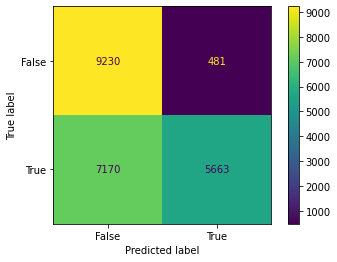

In [30]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()


Precision, Recall and F1_score for k-means clustering with k=2

Precision Score = TP / (FP + TP)

In [31]:
print('Precision: %.3f' % metrics.precision_score(test_df['target'],clusters_test))

Precision: 0.922


Recall Score = TP / (FN + TP)

In [32]:
print('Recall: %.3f' % metrics.recall_score(test_df['target'], test_df['cluster']))

Recall: 0.441


Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)

In [33]:
print('Accuracy: %.3f' % metrics.accuracy_score(test_df['target'], test_df['cluster']))

Accuracy: 0.661


In [34]:
print('F1_score: %.3f' % metrics.f1_score(test_df['target'], test_df['cluster']))

F1_score: 0.597


% of new attacks detected using k-means

In [35]:
test_df['new_attacks']=pd.read_csv("/content/drive/Shareddrives/kdd dataset/new_attack_list.csv")
test_df['new_attacks'].value_counts()

-1    18794
 1     3750
Name: new_attacks, dtype: int64

In [36]:
test_df['match_bin']=(test_df['cluster']==test_df['target'])

In [37]:
test_df['match_bin'].value_counts()

True     14893
False     7651
Name: match_bin, dtype: int64

In [38]:
count_attacks=3750
new_attack_detected=(test_df['new_attacks']==test_df['match_bin'])
print("% of new attacks detected:",sum(new_attack_detected)/count_attacks)

% of new attacks detected: 0.05653333333333333


saving test results after clustering

In [39]:
test_df.to_csv("/content/drive/Shareddrives/kdd dataset/clustered_test.csv",index=False)

Binary and multi class classification using knn method from sklearn.neighbors

In [40]:
train_df= pd.read_csv("/content/drive/Shareddrives/kdd dataset/binaryTraget_df.csv")
train_df_target_encoded=pd.read_csv("/content/drive/Shareddrives/kdd dataset/multiClassWithLabel_train_encoded.csv")

Test data loading 

In [41]:
test_df=pd.read_csv("/content/drive/Shareddrives/kdd dataset/processed_test_df.csv")
test_df_target_encoded=pd.read_csv("/content/drive/Shareddrives/kdd dataset/multiClassWithLabel_test_encoded.csv")

In [42]:
train_df_target_encoded.value_counts()

target_encoded
3                 67343
0                 45927
4                 11656
1                   995
2                    52
dtype: int64

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
X_train_bin=train_df.loc[:,train_df.columns!='target']
y_train_bin=train_df['target']
X_test_bin=test_df.loc[:,test_df.columns!='target']
y_test_bin=train_df['target']

In [45]:
knn_bin=KNeighborsClassifier(n_neighbors=2)
knn_bin.fit(X_train_bin,y_train_bin)

KNeighborsClassifier(n_neighbors=2)

In [46]:
y_pred_bin=knn_bin.predict(X_test_bin)

In [47]:
X_train=train_df.loc[:,train_df.columns!='target']
y_train=train_df_target_encoded

In [48]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [49]:
X_test=test_df.loc[:,test_df.columns!='target']
y_test=test_df_target_encoded

In [50]:
y_pred=knn.predict(X_test)

In [51]:
pd.DataFrame(y_pred).value_counts()

3    14662
0     7175
4      705
1        2
dtype: int64

In [52]:
confusion_matrix_multiClass = metrics.confusion_matrix(y_test,y_pred)

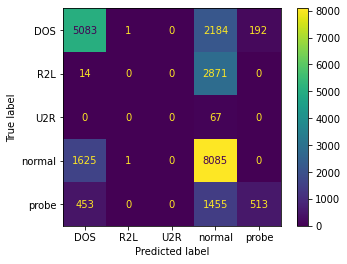

In [53]:
cm_display_multiClass = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_multiClass, display_labels = ['DOS', 'R2L','U2R','normal','probe'])

cm_display_multiClass.plot()
plt.show()

In [54]:
print("precision:",metrics.precision_score(y_test,y_pred,average=None))

precision: [0.70843206 0.         0.         0.55142545 0.72765957]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
print("accuray:",metrics.accuracy_score(y_test,y_pred))

accuray: 0.6068577004968062


% of new attacks detected

In [56]:
test_df['new_attacks']=pd.read_csv("/content/drive/Shareddrives/kdd dataset/new_attack_list.csv")
test_df['new_attacks'].value_counts()

-1    18794
 1     3750
Name: new_attacks, dtype: int64

In [57]:
test_df['match_bin']=(y_pred_bin==test_df['target'])

In [58]:
test_df['match_bin'].value_counts()

True     14449
False     8095
Name: match_bin, dtype: int64

In [59]:
count_attacks=3750
new_attack_detected=(test_df['new_attacks']==test_df['match_bin'])
print("% of new attacks detected:",sum(new_attack_detected)/count_attacks)

% of new attacks detected: 0.18186666666666668
